In [ ]:
# Este ambiente Python 3 vem com muitas bibliotecas analíticas úteis instaladas
# É definido pela imagem kaggle/python Docker: https://github.com/kaggle/docker-python
# Por exemplo, aqui estão vários pacotes úteis para carregar

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Sistemas de Recomendação com Python
Bem-vindo ao notebook de código para sistemas de recomendação com Python. Nesta palestra desenvolveremos sistemas básicos de recomendação usando Python e pandas.

Neste notebook, vamos nos concentrar em fornecer um sistema básico de recomendação sugerindo itens que são mais semelhantes a um determinado item, neste caso, filmes. Tenha em mente que este não é um verdadeiro sistema de recomendação robusto, para descrevê-lo com mais precisão, ele apenas informa quais filmes/itens são mais semelhantes à sua escolha de filme.

Não há projeto para este tópico, em vez disso, você tem a opção de trabalhar na versão de aula avançada deste notebook (totalmente opcional!).

Vamos começar!

**Import Libraries**

In [ ]:
df = pd.read_csv('/content/ratings.csv', sep=',')
df.rename(columns = {'movieId':'item_id'}, inplace = True)


In [ ]:
df.head()

,userId,item_id,ranking,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movie_titles = pd.read_csv("/content/movies.csv")
movie_titles.rename(columns = {'movieId':'item_id'}, inplace = True)
movie_titles.head()

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df = pd.merge(df,movie_titles,on='item_id' )
df.head()

,userId,item_id,ranking,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


*EDA*

**Let's explore the data a bit and get a look at some of the best rated movies.**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [ ]:
df.groupby('title')['ranking'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: ranking, dtype: float64

In [ ]:
df.groupby('title')['ranking'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: ranking, dtype: int64

In [ ]:
ratings = pd.DataFrame(df.groupby('title')['ranking'].mean())
ratings.head()

,ranking
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [ ]:
ratings['num of ranking'] = pd.DataFrame(df.groupby('title')['ranking'].count())
ratings.head()

,ranking,num of ranking
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


<Axes: >

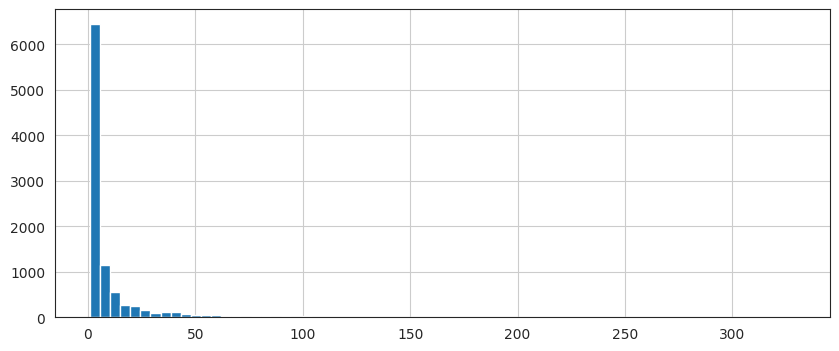

In [ ]:
plt.figure(figsize=(10,4))
ratings['num of ranking'].hist(bins=70)

<Axes: >

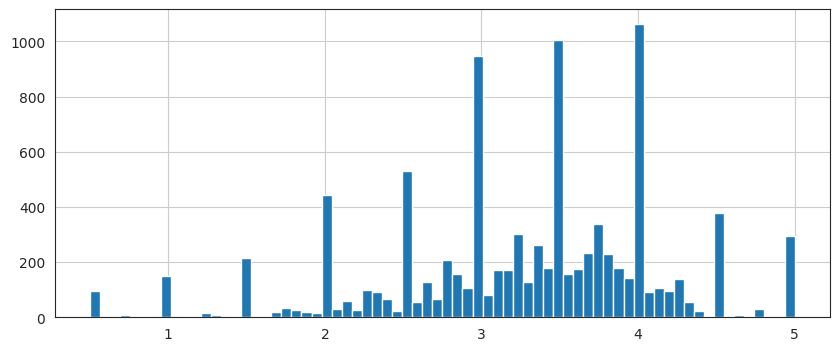

In [ ]:
plt.figure(figsize=(10,4))
ratings['ranking'].hist(bins=70)

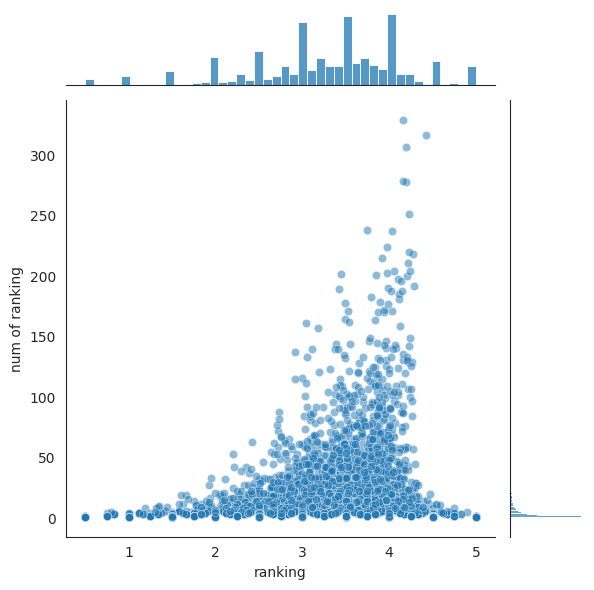

In [ ]:
sns.jointplot(x='ranking',y='num of ranking',data=ratings,alpha=0.5)

# **Recommending Similar Movies**

Agora vamos criar uma matriz que tenha os IDs dos usuários em um acesso e o título do filme em outro eixo. Cada célula consistirá na classificação que o usuário deu a esse filme. Observe que haverá muitos valores NaN, porque a maioria das pessoas não viu a maioria dos filmes.


In [ ]:

moviemat = df.pivot_table(index='userId',columns='title',values='ranking')
moviemat.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

ratings.sort_values('num of ranking',ascending=False).head(10)

,ranking,num of ranking
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


In [ ]:
ratings.head()

,ranking,num of ranking
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [ ]:
starwars_user_ratings = moviemat['Forrest Gump (1994)']
liarliar_user_ratings = moviemat['Pulp Fiction (1994)']
starwars_user_ratings.head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [ ]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [ ]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
"'burbs, The (1989)",0.197712
(500) Days of Summer (2009),0.234095
*batteries not included (1987),0.892710
...And Justice for All (1979),0.928571
10 Cent Pistol (2015),-1.000000


In [ ]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Lost & Found (1999),1.0
"Century of the Self, The (2002)",1.0
The 5th Wave (2016),1.0
Play Time (a.k.a. Playtime) (1967),1.0
Memories (Memorîzu) (1995),1.0
Playing God (1997),1.0
Killers (2010),1.0
"Girl Walks Home Alone at Night, A (2014)",1.0
Tampopo (1985),1.0


In [ ]:
corr_starwars = corr_starwars.join(ratings['num of ranking'])
corr_starwars.head()

,Correlation,num of ranking
title,,
"'burbs, The (1989)",0.197712,17
(500) Days of Summer (2009),0.234095,42
*batteries not included (1987),0.892710,7
...And Justice for All (1979),0.928571,3
10 Cent Pistol (2015),-1.000000,2


In [ ]:
corr_starwars[corr_starwars['num of ranking']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ranking
title,,
Forrest Gump (1994),1.000000,329
Good Will Hunting (1997),0.484042,141
Aladdin (1992),0.464268,183
American History X (1998),0.457287,129
"Truman Show, The (1998)",0.432556,125


In [ ]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ranking'])
corr_liarliar[corr_liarliar['num of ranking']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ranking
title,,
Pulp Fiction (1994),1.000000,307
Fight Club (1999),0.543465,218
Kill Bill: Vol. 1 (2003),0.504147,131
Trainspotting (1996),0.437714,102
Kill Bill: Vol. 2 (2004),0.421685,110
